<a href="https://colab.research.google.com/github/achett/Hierarchical-Model/blob/main/Revenue_FY23_Blind_Test_Enhancements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install hierarchicalforecast
# !pip install statsforecast
# !pip install datasetsforecast
# !pip install nixtlats>=0.1.0
!pip install darts
# !pip install mlforecast

In [ ]:
########################
# PACKAGES
########################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
from functools import reduce
from dateutil.relativedelta import relativedelta

# from statsforecast.core import StatsForecast
# from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoCES, AutoTheta
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder

# from hierarchicalforecast.core import HierarchicalReconciliation
# from hierarchicalforecast.evaluation import HierarchicalEvaluation
# from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, OptimalCombination, ERM, PERMBU, Bootstrap, Normality
# from hierarchicalforecast.utils import aggregate
# from nixtlats import TimeGPT
# os.environ['NIXTLA_ID_AS_COL'] = '1'


from darts import TimeSeries, concatenate
from darts.models import RegressionModel, LightGBMModel, ExponentialSmoothing, StatsForecastAutoETS, StatsForecastAutoARIMA, KalmanForecaster
from darts.dataprocessing.transformers import Scaler
from lightgbm import LGBMRegressor
from darts.metrics import mae, rmse, mape, mql, mse, ope
from darts.utils.likelihood_models import QuantileRegression

pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
##############
# PARAMS
##############
fct_periods = 15
fct_st_date = '2023-04-01'
fct_end_date = '2024-03-01'

# Create hierarchical structure and constraints
hierarchy_levels = [['TopLv'],
                    ['TopLv', 'ProductLv'],
                    ['TopLv', 'ProductLv', 'Lv1'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4'],
                    ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5']]

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/regional_hierarchy.xlsx'
sheet_name = 'regional_hierarchy v2'
r_hier = pd.read_excel(inputFile, sheet_name=sheet_name)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/model_selection.xlsx'
model_selection = pd.read_excel(inputFile)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/Product Naming Convention.xlsx'
product_naming_convention = pd.read_excel(inputFile)

In [ ]:
##############
# FUNCTIONS
##############
def prepare_data(data, r_hier):

    # Merge hierarchy
    data = data.merge(r_hier, how='inner', left_on='cost_object', right_on='Lv5')

    # Transform date and y
    data['ds'] = pd.to_datetime(data['ds'])
    data['y'] = data['y'].astype(float)

    # Address NA values
    data['y'] = data['y'].fillna(0)
    data['TopLv'] = data['TopLv'].fillna('')
    data['Lv1'] = data['Lv1'].fillna('')
    data['Lv2'] = data['Lv2'].fillna('')
    data['Lv3'] = data['Lv3'].fillna('')
    data['Lv4'] = data['Lv4'].fillna('')
    data['Lv5'] = data['Lv5'].fillna('')
    data['product'] = data['product'].fillna('')

    # Create hierarchical dataframe
    data.rename(columns={'product': 'ProductLv'}, inplace=True)
    data = data[['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'y']]

    # Replace '/' with '_' in the four columns
    data['TopLv'] = data['TopLv'].str.replace('/', '_')
    data['ProductLv'] = data['ProductLv'].str.replace('/', '_')
    data['Lv1'] = data['Lv1'].str.replace('/', '_')
    data['Lv2'] = data['Lv2'].str.replace('/', '_')
    data['Lv3'] = data['Lv3'].str.replace('/', '_')
    data['Lv4'] = data['Lv4'].str.replace('/', '_')
    data['Lv5'] = data['Lv5'].str.replace('/', '_')

    data['unique_id'] = data['TopLv'] + '/' + data['ProductLv'] + '/' + data['Lv1'] + '/' + data['Lv2'] + '/' + data['Lv3'] + '/' + data['Lv4'] + '/' + data['Lv5']

    # Assuming df is your existing DataFrame
    grouping_columns = ['TopLv', 'ProductLv', 'Lv1', 'Lv2', 'Lv3', 'Lv4', 'Lv5', 'ds', 'unique_id']  # All columns except 'y'

    # Group by specified columns and sum 'y'
    data = data.groupby(grouping_columns)['y'].sum().reset_index()

    return data

def prepare_feature(data, r_hier, volume_act2, feature_name):

    # Select and rename columns
    data = data[['cost_object', 'product', 'ds', feature_name]].rename(columns={feature_name: 'y'})

    # Apply any additional preparation (assuming prepare_data is a function you have defined)
    data = prepare_data(data, r_hier)

    # Rename the columns back
    data = data.rename(columns={'y': feature_name})

    # Merge with the volume_act2 dataframe
    merged_df = data.merge(volume_act2[['unique_id', 'ds']], how='right', on=['unique_id', 'ds'])

    return merged_df


In [ ]:
##############
# DATA LOAD
##############
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23.csv'
budget = pd.read_csv(inputFile)
# budget = budget[budget['category']=='EQUIV_UNIT - Equivalent Units']
budget = budget[budget['category']=='UC110000 - Total Revenue']
budget.rename(columns={'country': 'cost_object'}, inplace=True)
budget = prepare_data(budget, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/revenue_output.csv'
volume_act = pd.read_csv(inputFile)
volume_act.rename(columns={'value': 'y'}, inplace=True)
volume_act = prepare_data(volume_act, r_hier)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)

sga1 = prepare_feature(sga, r_hier, volume_act, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act, 'Field_Sales')

In [ ]:
########################
# IDENTIFY UNIVERSE
########################
tested_ts = set(budget['unique_id'].unique()).intersection(volume_act['unique_id'].unique())

# Find unique IDs present in budget_h but not in rev
unique_ids_in_budget_not_in_rev = set(budget['unique_id'].unique()).difference(volume_act['unique_id'].unique())

# Find unique IDs present in rev but not in budget_h
unique_ids_in_rev_not_in_budget = set(volume_act['unique_id'].unique()).difference(budget['unique_id'].unique())

# Filter volume
volume_act = volume_act[volume_act['unique_id'].isin(tested_ts)]

In [ ]:
########################
# SEGMENT TIME SERIES
########################
new_products = ['ENFORTUMAB - Enforumab Vedotin', 'ROXADUSTNT - Roxadustant']
loe_products = ['REGADENOSN - Regadenoson']
div_products = ['MICAFUNGIN - Micafungin Sodium']

new_ids = volume_act[volume_act['ProductLv'].isin(new_products)]['unique_id'].unique().tolist()
loe_ids = volume_act[volume_act['ProductLv'].isin(loe_products)]['unique_id'].unique().tolist()
divested_ids = volume_act[volume_act['ProductLv'].isin(div_products)]['unique_id'].unique().tolist()

# IDs with A&P and Field Sales Spend
grouped1 = sga1.groupby('unique_id')[['AP']].sum()
grouped2 = sga2.groupby('unique_id')[['Field_Sales']].sum()
spend_ids = set(grouped1[(grouped1['AP'] > 0)].index.tolist() + grouped2[(grouped2['Field_Sales'] > 0)].index.tolist())
spend_ids = spend_ids.difference(new_ids + loe_ids + divested_ids)

# IDs with no spend
non_spend_ids = volume_act[~volume_act['unique_id'].isin(spend_ids)]['unique_id'].unique()

# Model Selection
arima_regions = model_selection[model_selection['model']=='ARIMA']['Lv3'].unique()
ets_regions = model_selection[model_selection['model']=='ETS']['Lv3'].unique()
# arima_ids = volume_act[(volume_act['level3'].isin(arima_regions)) & (~volume_act['unique_id'].isin(spend_ids))]['unique_id'].unique().tolist()
# ets_ids = volume_act[(volume_act['level3'].isin(ets_regions)) & (~volume_act['unique_id'].isin(spend_ids))]['unique_id'].unique().tolist()

arima_ids = volume_act[(volume_act['Lv3'].isin(arima_regions))]['unique_id'].unique().tolist()
ets_ids = volume_act[(volume_act['Lv3'].isin(ets_regions))]['unique_id'].unique().tolist()

# Solifenacin _ Tamsulosin
solif_tams_ids = volume_act[volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin', 'TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique().tolist()
arima_ids = set(arima_ids+solif_tams_ids)
ets_ids = [id for id in ets_ids if id not in solif_tams_ids]

In [ ]:
########################
# DATA CONVERSION
########################
set2zero_list=['Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total/D_CN_TOTAL - China Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_BELGIUM - Belgium/D_E_BELGIUM - Belgium',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_BALKANS - Balkans/D_E_BOS_HER - Bosnia-Herz.',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_ADRCS_PT - Adriatics & Portugal/D_E_ADRCS - Adriatic Adriatics/D_E_CROATIA - Croatia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_CZECH - Czech',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France/D_E_FRANCE - France',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain/D_E_GB - Great Britain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_HUBGROGR - HBRG/D_E_HUBGRO - Hungary  Bulgaria & Romania/D_E_HU - Hungary',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_IE - Ireland/D_E_IE - Ireland/D_E_IE - Ireland',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BBMCI - BBMCI group/D_E_MTCYIS - Malta  Cyprus & Iceland/D_E_MALTA - Malta',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_NORDIC - Nordic/D_E_NORWAY - Norway/D_E_NORWAY - Norway',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_PO - Poland/D_E_PO - Poland',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain/D_E_SPAIN - Spain',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total/D_HK_TOTAL - Hong Kong Total',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus/D_I_CIS_BEL - Belarus',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt/D_I_EGYPT - Egypt',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia/D_I_INDONESIA - Indonesia',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq/D_I_IRAQ - Iraq',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan/D_I_JORDAN - Jordan',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_REST - Domestic Rest of Latam/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others/D_I_LATAM_REST_OTH - Domestic Rest of Latam Others',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_MEA_DB - Distributor Business/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon/D_I_LEBANON - Lebanon',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines/D_I_PHILIPPINES - Philippines',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_MEA_OB - MEA Own Business/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa/D_I_SAFRICA - South Africa',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_SINMAL - SINMAL/D_I_SINGAPORE - SINGAPORE/D_I_SINGAPORE - SINGAPORE',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_I_INTL - International Markets/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey/D_I_TURKEY - Turkey',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_I_INTL - International Markets/D_I_APAC_CORE - APAC CORE/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam/D_I_VIETNAM - Vietnam',
       'Global/TAMSULOSIN - Tamsulosin HCl/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
       'Global/TAMSUL_TAB - Tamsulosin tab/D_GCN - Greater China/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total/D_TW_TOTAL - Taiwan Total',
      'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy/D_E_IT - Italy',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_BENELUX - Benelux/D_E_NETHLND - Netherlands/D_E_NETHLND - Netherlands',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_CZSK - Czech + Slovakia/D_E_SLOVAKIA - Slovakia',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_E_ESTMKT - Established Markets/D_E_MSM - Mid Size Markets/D_E_PCSU - PCSU/D_E_UA - Ukraine/D_E_UA - Ukraine',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_LATAM - Domestic - LatAM/D_I_LATAM_DB - Domestic Latam Distributor Business/D_I_AR - Domestic Argentina/D_I_AR - Domestic Argentina',
       'Global/SOLIF_TAMS - Solifenacin _ Tamsulosin/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan/D_I_CIS_KAZ - Kazakhstan',
        'Global/ENZA - Enzalutamide/D_I_INTL - International Markets/D_I_RBK_CORE - RBK Core/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia/D_I_CIS_RUS - Russia']

volume_act.loc[(volume_act['unique_id'].isin(set2zero_list)) & (volume_act['ds'] < '2022-04-01'), 'y'] = 0

# **ORIGINAL RUN**

In [ ]:
########################
# SAMPLE
########################
ts2fix = ['Global/ROMOSOZUMA - ROMOSOZUMA/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/D_JPCOM - Japan Commercial/JP10 - Astellas Pharma Inc']

volume_act = volume_act[volume_act['unique_id'].isin(ts2fix)]


In [ ]:
########################
# RUN ETS & ARIMA
########################
def convert_fct2df(forecasts):
    forecast_dfs = []
    for unique_id, forecast_ts in forecasts.items():
        df = TimeSeries.quantiles_df(forecast_ts, quantiles=[0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995])
        df['unique_id'] = unique_id
        df = df.reset_index()
        df = df.rename(columns={'y_0.5': 'y'})
        forecast_dfs.append(df)

    # Concatenate all forecast DataFrames into a single DataFrame
    all_forecasts_df = pd.concat(forecast_dfs, axis=0)

    # Reorder and rename columns as needed
    columns = ['unique_id'] + [col for col in all_forecasts_df.columns if col != 'unique_id']
    all_forecasts_df = all_forecasts_df[columns]

    all_forecasts_df.columns.name = None

    return all_forecasts_df

def generate_time_series_dict(data, fct_periods, filter_data):
    # Split train/test sets
    test = data.groupby('unique_id').tail(fct_periods)
    train = data.drop(test.index)

    # Prepare time series dataframes
    time_series_dfs = {uid: group for uid, group in train.groupby('unique_id')}
    time_series_dict = {}

    if filter_data:
        # Filter out time series with insufficient non-zero data points
        filtered_time_series_dfs = {}
        for uid, group in time_series_dfs.items():
            non_zero_index = group['y'].ne(0).idxmax()
            start_index = max(0, non_zero_index - (13 - 1))
            filtered_df = group.loc[non_zero_index:] if group.loc[non_zero_index:].shape[0] >= 13 else group.loc[start_index:]
            if not filtered_df.empty:
                filtered_time_series_dfs[uid] = filtered_df
        # Convert each filtered DataFrame into a Darts TimeSeries object

        time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in filtered_time_series_dfs.items()}
    else:
        # Convert each original DataFrame into a Darts TimeSeries object without filtering
        time_series_dict = {uid: TimeSeries.from_dataframe(group, 'ds', 'y') for uid, group in time_series_dfs.items()}

    return time_series_dict

def generate_forecast(data, fct_periods, model2use, filter_data=True):

    # Use the nested function to generate the time series dictionary
    time_series_dict = generate_time_series_dict(data, fct_periods, filter_data)

    # Create and fit a model for each time series
    models = {}
    for uid, series in time_series_dict.items():
        model = get_model(model2use)
        model.fit(series)
        models[uid] = model

    # Forecasting
    fct_dict = {uid: model.predict(fct_periods, num_samples=1000) for uid, model in models.items()}

    # Convert forecasts into a dataframe
    fct_df = convert_fct2df(fct_dict)
    print('hi')
    return fct_dict, fct_df

# Function to dynamically get the model instance
def get_model(model_name):
    if model_name == 'AutoETS':
        return StatsForecastAutoETS()
    elif model_name == 'ARIMA':
        return StatsForecastAutoARIMA(season_length=12)
    elif model_name == 'KF':
        return KalmanForecaster(dim_x=12)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

# q = volume_act[volume_act['unique_id']=='Global/AMPHOTERCN - Amphotericin B/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/D_USCOM - US Commercial/US10 - Astellas Pharma US, Inc.']

# Check if 'ets_ids' list has values before running 'AutoETS' model
if ets_ids:
    ets_filtered_data = volume_act[volume_act['unique_id'].isin(ets_ids)]
    if not ets_filtered_data.empty:  # Also check if the filtered DataFrame is not empty
        ets_dict, ets_df = generate_forecast(ets_filtered_data, fct_periods, model2use='AutoETS', filter_data=True)

# Check if 'arima_ids' list has values before running 'ARIMA' model
if arima_ids:
    arima_filtered_data = volume_act[volume_act['unique_id'].isin(arima_ids)]
    if not arima_filtered_data.empty:  # Also check if the filtered DataFrame is not empty
        arima_dict, arima_df = generate_forecast(arima_filtered_data, fct_periods, model2use='ARIMA', filter_data=True)

# You can uncomment the following line if you want to always run 'KF' model regardless of filtering
# kf_fct = generate_forecast(volume_act, fct_periods, model2use='KF', filter_data=True)



hi


In [ ]:
########################
# XTREND - DECAY
########################
# import pandas as pd
# from dateutil.relativedelta import relativedelta
# import numpy as np

# def apply_exponential_decay(df, start_date, end_date, end_value_percentage, target_unique_ids):

#     # Convert 'ds' to datetime if it's not already and sort
#     df['ds'] = pd.to_datetime(df['ds'])
#     df = df.sort_values(by='ds')
#     start_date = pd.to_datetime(start_date)
#     end_date = pd.to_datetime(end_date)

#     # Loop through each group (unique_id)
#     for unique_id in target_unique_ids:
#         group = df[df['unique_id'] == unique_id]

#         # Columns to apply decay to
#         decay_columns = [col for col in group.columns if col not in ['unique_id', 'ds']]

#         # Initialize a dictionary to keep the end values for each decay column
#         end_values = {}

#         # Find start and end values and dates for each column
#         for col in decay_columns:
#             if start_date in group['ds'].values and end_date in group['ds'].values:
#                 start_value = group.loc[group['ds'] == start_date, col].iloc[0]
#                 end_value = start_value * end_value_percentage
#                 end_values[col] = end_value  # Store the end value for this column

#                 # Calculate the decay rate based on exponential decay formula
#                 months = relativedelta(end_date, start_date).months
#                 decay_rate = np.log(end_value / start_value) / months

#                 # Apply exponential decay for dates between start_date and end_date
#                 for date in pd.date_range(start_date, end_date):
#                     if date in group['ds'].values:
#                         t = relativedelta(date, start_date).months
#                         new_value = start_value * np.exp(decay_rate * t)
#                         df.loc[(df['unique_id'] == unique_id) & (df['ds'] == date), col] = new_value

#         # Replace column values for dates after end_date with the respective end values
#         for col, end_value in end_values.items():
#             if end_value is not None:  # Ensure there was an end value calculated
#                 df.loc[(df['unique_id'] == unique_id) & (df['ds'] > end_date), col] = end_value

#     return df


# # Apply exponential decay
# # lgbm_fct.rename(columns={'LGBM': 'y'}, inplace=True)
# ets_df.rename(columns={'ETS': 'y'}, inplace=True)
# arima_df.rename(columns={'ARIMA': 'y'}, inplace=True)

# # Micafungin
# arima_df = apply_exponential_decay(arima_df, '2023-07-01', '2023-08-01', 0, divested_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-07-01', '2023-08-01', 0, divested_ids)

# # Lexiscan
# arima_df = apply_exponential_decay(arima_df, '2023-01-01', '2023-12-01', .1, loe_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-01-01', '2023-12-01', .1, loe_ids)

# # # Tamsulosin
# # tamsulosin_ids = volume_act[volume_act['ProductLv'].isin(['TAMSULOSIN - Tamsulosin HCl', 'TAMSUL_TAB - Tamsulosin tab'])]['unique_id'].unique()
# # arima_df = apply_exponential_decay(arima_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)
# # ets_df = apply_exponential_decay(ets_df, '2023-04-01', '2023-12-01', .9, tamsulosin_ids)

# # Solifinacin Tamsulosin
# solif_tams_ids = volume_act[(volume_act['ProductLv'].isin(['SOLIF_TAMS - Solifenacin _ Tamsulosin'])) & (volume_act['Lv5'].isin(['D_E_PORTUGAL - Portugal', 'D_E_SPAIN - Spain', 'D_E_GB - Great Britain', 'D_E_BG - Bulgaria']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)
# ets_df = apply_exponential_decay(ets_df, '2023-06-01', '2023-12-01', .7, solif_tams_ids)

# # Xtandi
# xtandi_ids = volume_act[(volume_act['ProductLv'].isin(['ENZA - Enzalutamide']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)
# ets_df = apply_exponential_decay(ets_df, '2027-11-01', '2028-11-01', .1, xtandi_ids)

# # Mirabegron
# mira_ids = volume_act[(volume_act['ProductLv'].isin(['MIRABEGRON - Mirabegron']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2025-11-01', '2026-11-01', .1, mira_ids)
# ets_df = apply_exponential_decay(ets_df, '2025-11-01', '2026-11-01', .1, mira_ids)

# # Cresemba
# cres_ids = volume_act[(volume_act['ProductLv'].isin(['ISA_SULFAT - Isavuconazonium Sulfate']))]['unique_id'].unique()
# arima_df = apply_exponential_decay(arima_df, '2027-03-01', '2028-03-01', .1, cres_ids)
# ets_df = apply_exponential_decay(ets_df, '2027-03-01', '2028-03-01', .1, cres_ids)

In [ ]:
########################
# CREATE ANALYTICAL TABLE
########################
# # Subset
# volume_act_xsm = volume_act[['unique_id', 'ds', 'y']]
# budget2 = budget[['unique_id', 'ds', 'y']]
# ets_df2 = ets_df[['unique_id', 'ds', 'y']]
# arima_df2 = arima_df[['unique_id', 'ds', 'y']]

# # Assign names
# volume_act_xsm.rename(columns={'y': 'Actuals'}, inplace=True)
# budget2.rename(columns={'y': 'Budget'}, inplace=True)
# ets_df2.rename(columns={'y': 'ETS'}, inplace=True)
# arima_df2.rename(columns={'y': 'ARIMA'}, inplace=True)

# # Merge actuals, budget and forecast
# rev_at = volume_act_xsm.merge(ets_df2, on=['unique_id', 'ds'], how='left')
# rev_at = rev_at.merge(budget2, on=['unique_id', 'ds'], how='left')
# rev_at = rev_at.merge(arima_df2, on=['unique_id', 'ds'], how='left')

# # Conditions for selection
# conditions = [rev_at['unique_id'].isin(arima_ids),rev_at['unique_id'].isin(ets_ids)]
# choices = [rev_at['ARIMA'],rev_at['ETS']]

# # Creating the new column 'SelectedFCT' based on the conditions
# rev_at['SelectedFCT'] = np.select(conditions, choices, default=np.nan)

# # Only keep tested ts
# rev_at = rev_at[rev_at['unique_id'].isin(tested_ts)]

In [ ]:
########################
# CREATE DATA2PLOT
########################
# # Add revenue actuals
# data2plot = rev_at.copy()
# data2plot = data2plot[['unique_id', 'ds', 'Actuals']]
# data2plot['ds'] = pd.to_datetime(data2plot['ds'])

# # Update Actuals columns
# data2plot['Actuals (Train)'] = data2plot['Actuals'].copy()
# data2plot['Actuals'] = data2plot.apply(lambda row: row['Actuals'] if row['ds'] >= datetime.strptime(fct_st_date, "%Y-%m-%d") else None, axis=1)
# data2plot['Actuals (Train)'] = data2plot.apply(lambda row: row['Actuals (Train)'] if row['ds'] < datetime.strptime(fct_st_date, "%Y-%m-%d") else None, axis=1)

# # Add forecast and budget
# data2plot = data2plot.merge(rev_at[['unique_id', 'ds', 'SelectedFCT']], how='left', on=['unique_id', 'ds'])
# data2plot = data2plot.merge(rev_at[['unique_id', 'ds', 'Budget']], how='left', on=['unique_id', 'ds'])

# data2plot.head()

In [ ]:
########################
# PLOT
########################
# import ipywidgets as widgets
# from ipywidgets import interact
# import matplotlib.pyplot as plt
# import pandas as pd

# import pandas as pd
# import matplotlib.pyplot as plt
# from IPython.display import display, HTML
# import base64
# from io import BytesIO

# # Update the function to include filtering based on 'unique_id'
# def plot_data(unique_id):
#     # Define x_column and y_columns directly
#     x_column = data2use.columns[1]
#     y_columns = [data2use.columns[2], data2use.columns[3], data2use.columns[4], data2use.columns[5]]

#     # Filter data based on selected unique_id
#     filtered_data = data2use[data2use['unique_id'] == unique_id]

#     # Set up a 1x3 grid of subplots
#     fig, (ax1, ax4) = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'width_ratios': [4, 1]}) # Adjust layout for table

#     # Plotting multiple y-axes on the first subplot
#     for y_column in y_columns:
#         ax1.plot(filtered_data[x_column], filtered_data[y_column], label=y_column)
#     ax1.set_xlabel(x_column)
#     ax1.set_ylabel('Values')
#     ax1.set_title(f'Revenue for {unique_id}')
#     ax1.legend()

#     # Remove axis for table
#     ax4.axis('off')
#     ax4.axis('tight')

#     # Displaying the sum table
#     display_data = filtered_data[[x_column] + list(y_columns)].copy()
#     display_data = display_data[display_data['ds']>=fct_st_date]
#     display_data['ds'] = display_data['ds'].dt.strftime('%m/%d/%Y')

#     # Create a sum row
#     sum_values = {x_column: 'Sum'}
#     for col in list(y_columns):
#         sum_values[col] = display_data[col].sum()
#     sum_row = pd.DataFrame([sum_values])

#     # Create a % diff row
#     actuals_sum = sum_values['Actuals']
#     pdiff_values = {x_column: '% Diff'}
#     for col in list(y_columns):
#         pdiff_values[col] = ((display_data[col].sum()-actuals_sum) / actuals_sum) * 100 if actuals_sum != 0 else None
#         pdiff_values[col] = round(pdiff_values[col], 2)
#     perc_diff_row = pd.DataFrame([pdiff_values])

#     # Stack the sum row
#     display_data = pd.concat([sum_row, display_data], ignore_index=True)

#     # Round the values and add commas
#     for column in y_columns:
#         if column in display_data.columns:
#             # Round to two decimal places
#             display_data[column] = display_data[column].round(2)
#             # Format with commas
#             display_data[column] = display_data[column].apply(lambda x: f"{x:,.2f}")

#     # Stack the % diff and remove 'Actuals Train'
#     display_data = pd.concat([perc_diff_row, display_data], ignore_index=True)
#     display_data = display_data.drop('Actuals (Train)', axis=1)

#     # Convert perc_diff_data to array for table
#     table_data = display_data.to_numpy()
#     # Add table at the right
#     table = ax4.table(cellText=table_data, colLabels=display_data.columns, loc='right')
#     table.auto_set_font_size(False)
#     table.set_fontsize(8.5)  # Set smaller font size if necessary
#     table.scale(4, 1.8)  # Adjust scale to fit

#     plt.tight_layout()
#     plt.show()


# # data2use = ts2fix
# # data2use = tsnonspend
# data2use = data2plot
# # data2use = rev_at_hier2plot

# substring1 = 'romos'
# substring2 = 'romos'

# # Update data2use to include rows where 'unique_id' contains either substring1 or substring2
# # data2use = data2use[data2use['unique_id'].str.contains(substring1 + '|' + substring2, case=False, na=False)]

# # data2use = data2use[data2use['unique_id'].str.contains(substring1, case=False, na=False) &
# #                     data2use['unique_id'].str.contains(substring2, case=False, na=False)]



# # Create widgets
# unique_id_selector = widgets.SelectionSlider(
#     options=data2use['unique_id'].unique(),
#     description='unique_id:',
#     orientation='horizontal',
#     readout=True
# )

# # Display interactive plot
# interact(plot_data, unique_id=unique_id_selector)

#**TEST RUNS**

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ast
import random

# Set the seed
random.seed(42)


# REFERENCE FOR SYNTAX

# unrestricted_model_mira_gb = {
#     'irregular': False, 'autoregressive': None,
#     'level': True, 'stochastic_level': True,
#     'trend': True, 'stochastic_trend': False,
#     'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False,
#     'seasonal': None, 'stochastic_seasonal': True,
#     'freq_seasonal':[{'period': 12,'harmonics': 50}]
# }

In [ ]:

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings.csv'
unrestricted_model_settings = pd.read_csv(inputFile, dtype={'autoregressive': 'Int64', 'seasonal': 'Int64'})

# Define a safe literal eval function that checks for NaN values
def safe_literal_eval(s):
    if pd.isna(s):
        return None  # or you can return another appropriate value like an empty list or dict
    else:
        return ast.literal_eval(s)

# Apply the safe_literal_eval function
unrestricted_model_settings['freq_seasonal'] = unrestricted_model_settings['freq_seasonal'].apply(safe_literal_eval)
unrestricted_model_settings['exog'] = unrestricted_model_settings['exog'].apply(safe_literal_eval)

# unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']=='Bud')]

# Filter and drop
unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']!='No Data')]
unrestricted_model_settings = unrestricted_model_settings.drop(['Success', 'LostinOrig', '%ofSales'], axis=1)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)
sga1 = prepare_feature(sga, r_hier, volume_act, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act, 'Field_Sales')
sga3 = prepare_feature(sga, r_hier, volume_act, 'Smoothed_AP')
sga4 = prepare_feature(sga, r_hier, volume_act, 'Smoothed_Field_Sales')

sga_exog = sga1.merge(sga2[['unique_id', 'ds', 'Field_Sales']], how='left', on=['unique_id', 'ds'])
sga_exog = sga_exog.merge(sga3[['unique_id', 'ds', 'Smoothed_AP']], how='left', on=['unique_id', 'ds'])
sga_exog = sga_exog.merge(sga4[['unique_id', 'ds', 'Smoothed_Field_Sales']], how='left', on=['unique_id', 'ds'])

In [ ]:
unrestricted_model_settings.shape

(618, 15)

In [ ]:
product2test = 'ROMOSOZUMA - ROMOSOZUMA'
lv52test = 'JP10 - Astellas Pharma Inc'
id_row = unrestricted_model_settings[(unrestricted_model_settings['Product'] == product2test) & (unrestricted_model_settings['Lv5'] == lv52test)]
id_row

,Product,Lv5,irregular,autoregressive,level,stochastic_level,trend,stochastic_trend,cycle,damped_cycle,stochastic_cycle,seasonal,stochastic_seasonal,freq_seasonal,exog
5,ROMOSOZUMA - ROMOSOZUMA,JP10 - Astellas Pharma Inc,True,4,True,True,True,True,False,False,False,12,True,None,None


In [ ]:


id_row = unrestricted_model_settings.iloc[0]
product2test = id_row['Product']
lv52test = id_row['Lv5']
model_settings = id_row.drop(['Product', 'Lv5']).to_dict()
print(product2test)
print(lv52test)

# Determine unique ID based on product and Lv5
id2test = volume_act[(volume_act['ProductLv']==product2test) & (volume_act['Lv5']==lv52test)]['unique_id'].unique()[0]

model_settings = {
    'irregular': model_settings['irregular'], 'autoregressive': model_settings['autoregressive'],
    'level': model_settings['level'], 'stochastic_level': model_settings['stochastic_level'],
    'trend': model_settings['trend'], 'stochastic_trend': model_settings['stochastic_trend'],
    'cycle': model_settings['cycle'], 'damped_cycle': model_settings['damped_cycle'], 'stochastic_cycle': model_settings['stochastic_cycle'],
    'seasonal': 12, 'stochastic_seasonal': model_settings['stochastic_seasonal'], 'freq_seasonal': model_settings['freq_seasonal']
}

print(model_settings)

ENZA - Enzalutamide
US10 - Astellas Pharma US, Inc.
{'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True, 'freq_seasonal': None}


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

sga_exog_data = sga_exog[(sga_exog['ProductLv']==product2test) & (sga_exog['Lv5']==lv52test)]

ssm_data = volume_act.copy()
ssm_data = ssm_data[ssm_data['unique_id']==id2test]

# Add exog variables
exog_names = ['AP', 'Field_Sales', 'Smoothed_AP', 'Smoothed_Field_Sales']
ssm_data = ssm_data.merge(sga_exog_data[['unique_id', 'ds']+exog_names], how='left', on=['unique_id', 'ds'])
ssm_data.loc[:, exog_names] = ssm_data.loc[:, exog_names].fillna(0)

ssm_data = ssm_data[['ds', 'y']+exog_names]

ssm_data = ssm_data.set_index('ds')
ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

# lag = 15
# test_result = grangercausalitytests(ssm_data[['y', 'Field_Sales']], maxlag=lag)

# p_value = test_result[lag][0]['ssr_chi2test'][1]  # Get the p-value

# p_value

In [ ]:
# Set n, the number of months to lag
n_ap = 0
n_fs = 5

ssm_data['AP_lagged'] = ssm_data['AP'].shift(n_ap).fillna(0)
ssm_data['FS_lagged'] = ssm_data['Field_Sales'].shift(n_fs).fillna(0)
ssm_data['smAP_lagged'] = ssm_data['Smoothed_AP'].shift(n_ap).fillna(0)
ssm_data['smFS_lagged'] = ssm_data['Smoothed_Field_Sales'].shift(n_fs).fillna(0)

# Set train and test period
ssm_test = ssm_data.tail(fct_periods)
ssm_train = ssm_data.drop(ssm_test.index)

# Exogenous
# exog_var = ['FS_lagged', 'AP_lagged']
exog_var = ['FS_lagged']
# exog_var = ['AP_lagged']

exog_train = ssm_train[exog_var]
exog_test = ssm_test[exog_var]

# # Log
# ssm_train['y'] = np.log(ssm_train['y'])

# # Fit Model
# mod = sm.tsa.UnobservedComponents(ssm_train['y'], **model_settings)
# res = mod.fit(method='powell', disp=False)
# predict = res.get_prediction() # Perform prediction and forecasting
# forecast = res.get_forecast('2024-03-01')

# Fit Model with covariate
mod = sm.tsa.UnobservedComponents(ssm_train['y'], exog = exog_train, **model_settings)
res = mod.fit(method='powell', disp=False)
predict = res.get_prediction(exog = exog_test) # Perform prediction and forecasting
forecast = res.get_forecast('2024-03-01', exog = exog_test)

# print(res.summary())

# forecast_fy23_values = np.exp(forecast.predicted_mean)
forecast_fy23_values = forecast.predicted_mean

actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
forecast_fy23 = forecast_fy23_values.loc[forecast_fy23_values.index >= fct_st_date].sum()

error = ((forecast_fy23-actuals_fy23)/actuals_fy23)*100
error

1.1548911603638354

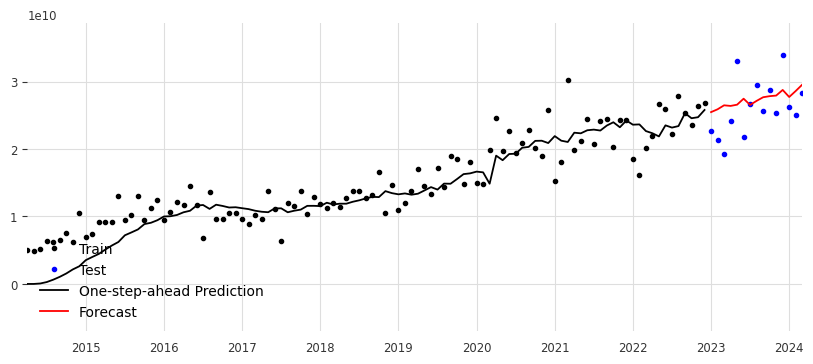

In [ ]:
exog_var2plot = ['AP_lagged']

fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
ssm_train['y'].plot(ax=ax, style='k.', label='Train')
ssm_test['y'].plot(ax=ax, style='b.', label='Test')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
# ssm_data['AP_lagged'].plot(ax=ax, style='g.', label='AP')
# ssm_data['FS_lagged'].plot(ax=ax, style='y.', label='FS')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='lower left');


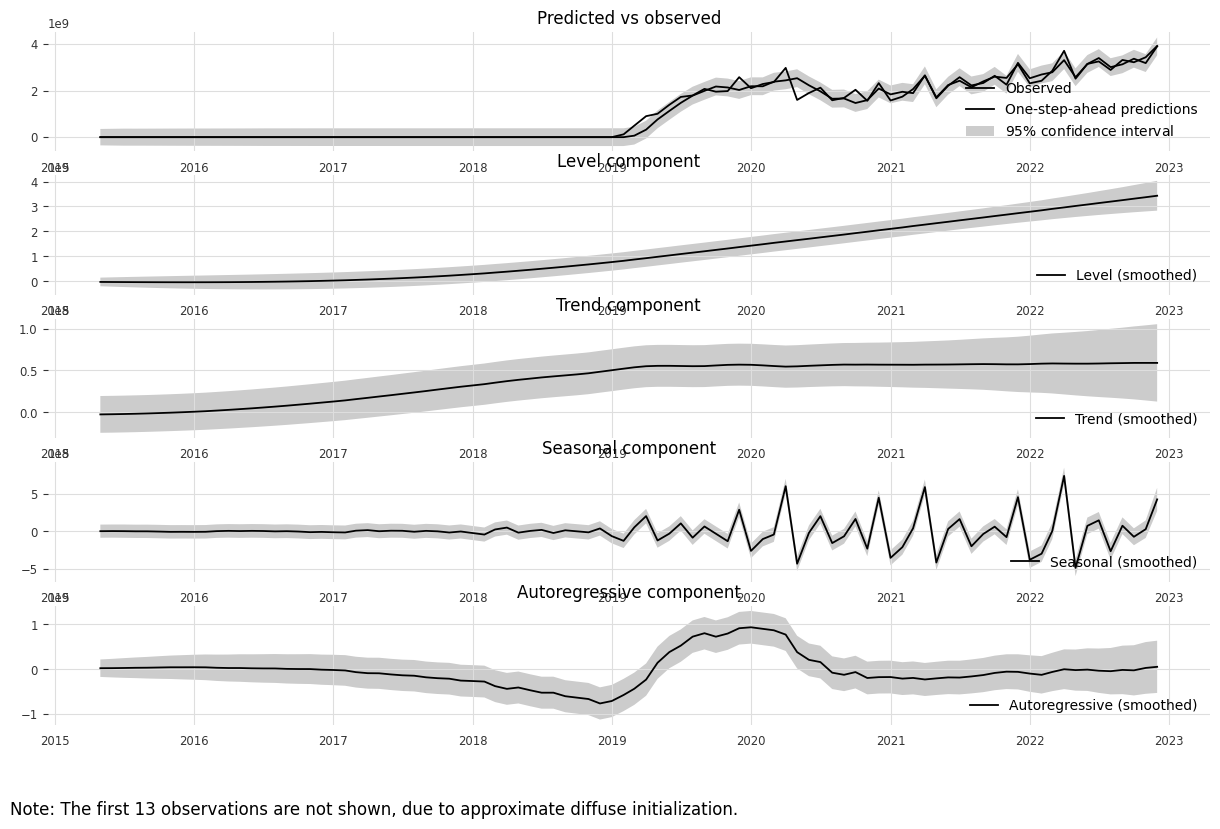

In [ ]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

# **PARAMETER OPTIMIZATION**

In [ ]:
# Select combinations to run for
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings.csv'
unrestricted_model_settings = pd.read_csv(inputFile, dtype={'autoregressive': 'Int64', 'seasonal': 'Int64'})

unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['LostinOrig']!=1)]

combinations = unrestricted_model_settings[['Product', 'Lv5']]

# To dictionary
combinations = combinations.rename(columns={'Product': 'product2test', 'Lv5': 'lv52test'}).to_dict(orient='records')

combinations = combinations[248:]

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import product

def optimize_uc_model(data_train, data_test):
    # Seasonal and autoregressive
    seasonal_values = [3, 6, 12, 18]
    ar_values = [None]  # Updated to include None
    level_values = [1]

    # Define all possible values for each boolean parameter
    boolean_params = [0, 1]

    # Create all combinations of parameters
    all_combinations = list(product(boolean_params, range(len(ar_values)), level_values, boolean_params,
                                    boolean_params, boolean_params, boolean_params, boolean_params,
                                    boolean_params, seasonal_values, boolean_params))

    best_error = float('inf')
    best_params = None

    # Iterate over all combinations
    for combo in all_combinations:
        model_params = {
            'irregular': bool(combo[0]),
            'autoregressive': ar_values[combo[1]],  # Use index to fetch correct value, including None
            'level': bool(combo[2]),
            'stochastic_level': bool(combo[3]),
            'trend': bool(combo[4]),
            'stochastic_trend': bool(combo[5]),
            'cycle': bool(combo[6]),
            'damped_cycle': bool(combo[7]),
            'stochastic_cycle': bool(combo[8]),
            'seasonal': combo[9],
            'stochastic_seasonal': bool(combo[10])
        }

        try:
            # Fit the model
            mod = sm.tsa.UnobservedComponents(data_train['y'], **model_params)
            res = mod.fit(method='powell', disp=False)

            # Forecasting
            forecast = res.get_forecast(steps=len(data_test))
            forecast_values = forecast.predicted_mean

            actuals = data_test['y'].sum()
            forecasted = forecast_values.sum()

            # Calculate error
            error = ((forecasted - actuals) / actuals) * 100

            # Store the best parameters
            if np.abs(error) < np.abs(best_error):
                best_error = error
                best_params = model_params
                print(f"New best error: {best_error} with params: {best_params}")
        except Exception as e:
            print(f"An error occurred with params {model_params}: {e}")

    return best_params, best_error



# DataFrame to store results
results_df = pd.DataFrame(columns=['Product', 'Market'])  # Initialize with only these two columns

# Loop over each combination
for combo in combinations:
    product2test = combo['product2test']
    lv52test = combo['lv52test']

    # Fetch unique ID for the current combination
    id2test = volume_act[(volume_act['ProductLv'] == product2test) & (volume_act['Lv5'] == lv52test)]['unique_id'].unique()[0]

    # Filter and prepare data
    ssm_data = volume_act[volume_act['unique_id'] == id2test]
    ssm_data = ssm_data[['ds', 'y']]
    ssm_data = ssm_data.set_index('ds')
    ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

    # Split data into training and testing sets
    ssm_test = ssm_data.tail(fct_periods)
    ssm_train = ssm_data.drop(ssm_test.index)

    # Run optimization
    best_params, minimum_error = optimize_uc_model(ssm_train, ssm_test)

    # Extract each parameter into its own column and create a single-row DataFrame
    param_data = {'Product': product2test, 'Market': lv52test}
    param_data.update(best_params)  # This adds each key-value pair from best_params as a column
    param_data['Minimum Error'] = minimum_error

    # Append results to the main results DataFrame
    current_result = pd.DataFrame([param_data])  # List of dictionary ensures single row
    results_df = pd.concat([results_df, current_result], ignore_index=True)

# Rearrange columns to ensure Minimum Error is the third column
cols = results_df.columns.tolist()
cols.insert(2, cols.pop(cols.index('Minimum Error')))  # Move 'Minimum Error' to third position
results_df = results_df[cols]

results_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/results/Blind Test FY23/optimized_params17.csv', index=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -99.9941937957974 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99341244680987 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -56.76357147835107 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -53.437290687432416 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: -46.85358361416062 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -38.665196546387435 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -36.19716749391439 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: -36.130533549270226 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -29.732292193652494 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -19.85440973988316 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -19.175669709409863 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


New best error: -18.2741673643344 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -17.714582815200792 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: -16.647866253450502 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


New best error: -16.0654843914904 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -15.525601106954067 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -14.799673299536234 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -14.713614035847586 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.99476348360304 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99054438057651 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: 2.8901611449844453 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: 2.8876410592840034 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}
New best error: 2.887640358516893 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: 2.8856471997187936 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -0.06646884505660208 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -0.05904490858576753 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: 0.006602915036620828 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
New best error: 0.006536732754712268 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99948759895545 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -96.8974528700668 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -96.27906438451996 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -50.031292424833616 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -49.85420239344256 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -47.01329693239076 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: -45.59717347364972 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': Tru

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


New best error: -11.291638376209146 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -6.928498665016631 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))


New best error: -6.9229873719141395 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}
New best error: -2.563045781883793 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: 2.27631190835751 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: -0.7251846615899362 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend'

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99993088477139 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.99971258975707 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: -99.99968027102703 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99967087785073 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: 11.908722756339332 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: 11.83744222707848 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: 9.54287824633656 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -1.5383465253366753 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99610719848707 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.99608195478434 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99300999939261 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.99060560842997 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr

New best error: -99.81203344200615 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: Specif

New best error: -79.33389984440028 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -72.85260304193628 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -47.73980842597123 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: -47.45543690501084 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -47.02450074249671 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

New best error: -16.976075151563126 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}
New best error: -8.172355034184928 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
New best error: -7.997910542635387 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -7.338037480310675 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
New best error: -2.2715279714537977 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -2.2067744611339495 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -2.1450256240870416 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: 0.21804178562332296 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: 0.21643433988601957 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

New best error: 0.21574866623984582 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.99691562844694 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.9964845283539 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/opt

New best error: -79.9881816567931 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -66.90496468382248 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99930259757322 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -50.557922911047925 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -48.88055872045927 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -48.13673081432223 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -27.26927956012747 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: 7.968485346296436 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -3.185574152790671 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.97188052491069 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.95312419697085 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -37.864401313614735 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -31.299587700595872 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -26.352231477956956 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -22.480431500001714 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -18.584038696081738 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -2.5663287401154475 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -1.2329116192417842 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -1.2329116192300051 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.99985657007238 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.99970148688556 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -63.82424526384105 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: -63.82311098881625 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -63.823041009547396 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -63.822011721316876 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
New best error: -63.39828079675899 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -62.341874522532 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -51.42560328437706 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: -49.96907615837971 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -40.84772973396436 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}
New best error: -38.79653370524481 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.98124452247089 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.97374830129743 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.96712453152739 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -11.371738233569415 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -11.366862933923324 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: -11.3648912117963 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -11.331355334794516 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -11.330187689977771 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWar

New best error: -11.243513131345345 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -11.241770539895093 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python

New best error: -6.908745669313025 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -6.906011535790488 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: -6.904770316137059 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: -6.904545081637166 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -6.776105355599666 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.99863673897465 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.99557576652208 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: 5.410725725597578 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr

New best error: 4.225130957271659 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -0.7313827096008816 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.98398629583906 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: 10.944348993889106 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1030: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not c

New best error: -99.99816576006674 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.99730351087078 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.99647516541383 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by

New best error: -99.34322338942005 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -86.63598006556607 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -62.95140850375006 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -99.98942680140311 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -25.232193569817486 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -12.798183181123058 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -11.985899821087962 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: 1.835896161566698 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: 1.230592816200577 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': False}
New best error: 1.2269566588970517 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1


New best error: 0.5035771261686082 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: 0.4973918703254523 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True, 'seasonal': 18, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.1

New best error: 0.49313432669878515 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 12, 'stochastic_seasonal': False}
New best error: 0.48546282186557926 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: 0.4777716838178761 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: 0.4693429891891138 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: 0.4514261911295252 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -98.76273001076818 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -98.33440449986325 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -97.6087027089664 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -60.41707108319546 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -9.732200300211826 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -2.5178753671990366 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 12, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -1.4358104859355927 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -1.4328980484516596 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': True, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: 1.3662614522577938 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: 0.1948638750703611 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -0.06678561958475336 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -99.33391648383974 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -98.75760457166244 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -98.68509365352297 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -98.5431392441084 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -47.76733373796494 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -46.797396597446436 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -46.56074228998352 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -38.703554663427404 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: -31.96547362179856 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: -31.952631741598857 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': False, 'seasonal': 18, 'stochastic_seasonal': False}
New best error: -29.653690885039673 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': True, 'tr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1037: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[offset]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespa

New best error: -99.06020007704299 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -99.05725214575266 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -98.03859644834428 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}
New best error: -97.73462030653573 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -97.1269936987738 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"


New best error: -54.50999084099175 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Spec

New best error: -9.65375690041858 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}
New best error: -6.4677913915143606 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

New best error: -4.311113497701686 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py

New best error: 0.9512350352637429 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 3, 'stochastic_seasonal': True}
New best error: -0.48949756391044197 with params: {'irregular': True, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': True, 'damped_cycle': False, 'stochastic_cycle': True, 'seasonal': 6, 'stochastic_seasonal': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1080: RuntimeWarning: divide by zero encountered in log
  unconstrained[offset] = np.log(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:3533: RuntimeWarning: invalid value encountered in subtract
  direc1 = x - x1
/usr/local/lib/python3.10/dist-packages/statsmode

New best error: -100.0 with params: {'irregular': False, 'autoregressive': None, 'level': True, 'stochastic_level': False, 'trend': False, 'stochastic_trend': False, 'cycle': False, 'damped_cycle': False, 'stochastic_cycle': False, 'seasonal': 3, 'stochastic_seasonal': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stochastic element;"
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:508: SpecificationWarning: Specified model does not contain a stochastic element; irregular component added.
  warn("Specified model does not contain a stoch

TypeError: 'NoneType' object is not iterable

In [ ]:
results_df

,Product,Market,irregular,autoregressive,level,stochastic_level,trend,stochastic_trend,cycle,damped_cycle,stochastic_cycle,seasonal,stochastic_seasonal,Minimum Error
0,SOLIFENACN - Solifenacin Succinate,D_E_MONTENEGRO - Montenegro,True,None,True,True,True,True,True,False,True,6.00,False,-14.71
1,TAMSUL_TAB - Tamsulosin tab,D_E_GB - Great Britain,False,None,True,True,True,True,True,True,False,18.00,True,0.01
2,FEZO - Fezolinetant,D_I_AU_TOTAL - Australia Total,False,None,True,False,False,False,False,False,False,3.00,False,-100.00
3,MICAFUNGIN - Micafungin Sodium,D_E_SLVNA - Slovenia,True,None,True,True,False,True,True,True,False,12.00,False,-0.73
4,MICAFUNGIN - Micafungin Sodium,D_E_AUSTRIA - Austria,True,None,True,True,True,True,True,True,False,18.00,False,-1.54
5,ROXADUSTNT - Roxadustant,D_E_BG - Bulgaria,False,None,True,False,False,False,False,False,False,3.00,False,-100.00
6,ESCHERICH - Escherichia coli ext,D_I_CIS_KAZ - Kazakhstan,True,None,True,True,False,True,True,True,True,12.00,True,0.22
7,MICAFUNGIN - Micafungin Sodium,D_E_CROATIA - Croatia,False,None,True,False,True,False,False,False,False,3.00,True,-66.90
8,MICAFUNGIN - Micafungin Sodium,D_E_PORTUGAL - Portugal,True,None,True,True,True,True,True,False,True,12.00,False,-3.19
9,MIRABEGRON - Mirabegron,D_E_RS - Serbia,True,None,True,False,True,True,False,False,False,18.00,True,-1.23


# **BULK RUN**

In [ ]:
def forecast_error(df, volume_act, exog_df, fct_periods, fct_st_date):
    # Initialize the output DataFrame
    results = pd.DataFrame(columns=['id2test', 'Product', 'Lv5', 'actuals_fy23', 'forecast_fy23', 'error'])

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        product = row['Product']
        Lv5 = row['Lv5']
        model_settings = row.drop(['Product', 'Lv5', 'exog']).to_dict()

        if row['exog']:
            exog2include = {k: v for d in row['exog'] for k, v in d.items()}
            exog_names = list(exog2include.keys())
        else:
            exog2include = None
            exog_names = []

        print(exog2include)
        print(product)
        print(Lv5)
        # Determine unique ID based on product and Lv5
        id2test = volume_act[(volume_act['ProductLv'] == product) & (volume_act['Lv5'] == Lv5)]['unique_id'].unique()[0]

        # Filter the data for this specific ID
        ssm_data = volume_act[volume_act['unique_id'] == id2test]

        # Add exog variables
        ssm_data = ssm_data.merge(exog_df[['unique_id', 'ds'] + exog_names], how='left', on=['unique_id', 'ds'])
        ssm_data = ssm_data[['ds', 'y'] + exog_names]

        # Efficiently fill NaNs with 0 in the specified columns
        ssm_data.loc[:, exog_names] = ssm_data.loc[:, exog_names].fillna(0)

        if exog2include is not None:
            for column, lag in exog2include.items():
                # Create new lagged column for each key in the dictionary
                ssm_data[column] = ssm_data[column].shift(lag).fillna(0)

        # Set ds as index
        ssm_data = ssm_data.set_index('ds')
        ssm_data.index = pd.DatetimeIndex(ssm_data.index.values, freq=ssm_data.index.inferred_freq)

        # Set train and test period
        ssm_test = ssm_data.tail(fct_periods)
        ssm_train = ssm_data.drop(ssm_test.index)
        print(ssm_train[exog_names])

        if row['exog']:
            exog_test = ssm_test[exog_names]
            exog_train = ssm_train[exog_names]
        else:
            exog_test = None
            exog_train = None

        # Fit the model
        mod = sm.tsa.UnobservedComponents(ssm_train['y'], exog = exog_train, **model_settings)
        res = mod.fit(method='powell', disp=False)

        # Perform prediction and forecasting
        predict = res.get_prediction(exog = exog_test)
        forecast = res.get_forecast('2024-03-01', exog = exog_test)

        actuals_fy23 = ssm_test.loc[ssm_test.index >= fct_st_date]['y'].sum()
        forecast_fy23 = forecast.predicted_mean.loc[forecast.predicted_mean.index >= fct_st_date].sum()

        error = ((forecast_fy23 - actuals_fy23) / actuals_fy23) * 100

        new_row = pd.DataFrame({
            'id2test': [id2test],
            'Product': [product],
            'Lv5': [Lv5],
            'actuals_fy23': [actuals_fy23],
            'forecast_fy23': [forecast_fy23],
            'error': [error]
        })

        # Using concat to append the new row
        results = pd.concat([results, new_row], ignore_index=True)

    return results

In [ ]:
import ast

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/unrestricted_model_settings.csv'
unrestricted_model_settings = pd.read_csv(inputFile, dtype={'autoregressive': 'Int64', 'seasonal': 'Int64'})

# Define a safe literal eval function that checks for NaN values
def safe_literal_eval(s):
    if pd.isna(s):
        return None  # or you can return another appropriate value like an empty list or dict
    else:
        return ast.literal_eval(s)

# Apply the safe_literal_eval function
unrestricted_model_settings['freq_seasonal'] = unrestricted_model_settings['freq_seasonal'].apply(safe_literal_eval)
unrestricted_model_settings['exog'] = unrestricted_model_settings['exog'].apply(safe_literal_eval)

# Filter and drop
unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Success']!='No Data')]
unrestricted_model_settings = unrestricted_model_settings.drop(['Success', 'LostinOrig', '%ofSales'], axis=1)

inputFile = '/content/drive/MyDrive/Colab Notebooks/SGA Prediction/data/sga_output.csv'
sga = pd.read_csv(inputFile)
sga1 = prepare_feature(sga, r_hier, volume_act, 'AP')
sga2 = prepare_feature(sga, r_hier, volume_act, 'Field_Sales')
sga_exog = sga1.merge(sga2[['unique_id', 'ds', 'Field_Sales']], how='left', on=['unique_id', 'ds'])

In [ ]:
product2test = 'ENZA - Enzalutamide'
lv52test = 'US10 - Astellas Pharma US, Inc.'

unrestricted_model_settings = unrestricted_model_settings[(unrestricted_model_settings['Product']==product2test) & (unrestricted_model_settings['Lv5']==lv52test)]

unrestricted_model_settings

,Product,Lv5,irregular,autoregressive,level,stochastic_level,trend,stochastic_trend,cycle,damped_cycle,stochastic_cycle,seasonal,stochastic_seasonal,freq_seasonal,exog
0,ENZA - Enzalutamide,"US10 - Astellas Pharma US, Inc.",True,<NA>,True,True,True,True,True,False,True,6,True,None,[{'Field_Sales': 5}]


In [ ]:
# Assuming 'budget' is your DataFrame
grouped_budget = budget.groupby(['unique_id'])['y'].sum().reset_index()
grouped_budget.columns=['id2test', 'budget_fy23']

# Calculate the number of chunks
num_rows = len(unrestricted_model_settings)
chunk_size = 50  # Process 5 rows at a time
num_chunks = (num_rows // chunk_size) + (1 if num_rows % chunk_size else 0)

start_chunk = 1
# num_chunks = 1

# Create dataframe to concat to
results2comp_full = pd.DataFrame(columns=['winner','Lv5', 'Product', 'actuals_fy23', 'forecast_fy23', 'budget_fy23', 'error', 'bud_error', 'id2test'])

# Loop through each chunk
for i in range(start_chunk - 1, num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size

    # Get the subset of the DataFrame
    subset = unrestricted_model_settings.iloc[start_index:end_index]

    # Check if the subset is empty (this might occur if your total rows are exactly divisible by the chunk size)
    if subset.empty:
        break

    # Run the function
    results_df = forecast_error(subset, volume_act, sga_exog, fct_periods, fct_st_date)

    # Display the grouped and summed DataFrame
    results2comp = results_df.merge(grouped_budget, how='left', on='id2test')
    results2comp['bud_error'] = ((results2comp['budget_fy23'] - results2comp['actuals_fy23']) / results2comp['actuals_fy23']) * 100
    results2comp['winner'] = np.where(np.abs(results2comp['error']) < np.abs(results2comp['bud_error']), 'Dx', 'Bud')
    results2comp = results2comp[['winner','Lv5', 'Product', 'actuals_fy23', 'forecast_fy23', 'budget_fy23', 'error', 'bud_error', 'id2test']]

    # Concat
    results2comp_full = pd.concat([results2comp_full, results2comp], ignore_index=True)

results2comp_full.shape

{'Field_Sales': 5}
ENZA - Enzalutamide
US10 - Astellas Pharma US, Inc.
              Field_Sales
2014-04-01           0.00
2014-05-01           0.00
2014-06-01           0.00
2014-07-01           0.00
2014-08-01           0.00
...                   ...
2022-08-01 406,241,129.66
2022-09-01 311,456,701.62
2022-10-01 344,655,623.30
2022-11-01 364,927,174.38
2022-12-01 342,455,951.24

[105 rows x 1 columns]


(1, 9)

In [ ]:
results2comp_full

,winner,Lv5,Product,actuals_fy23,forecast_fy23,budget_fy23,error,bud_error,id2test
0,Dx,"US10 - Astellas Pharma US, Inc.",ENZA - Enzalutamide,"328,335,702,093.75","327,645,102,460.93","329,374,997,103.66",-0.21,0.32,Global/ENZA - Enzalutamide/D_USCOM - US Commer...


In [ ]:
# Create ID
results2comp_full['ID'] = results2comp_full['Product'] + results2comp_full['Lv5']

# Save the output to a CSV file, naming them uniquely
results2comp_full.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/results/Blind Test FY23/results_summary.csv', index=False)